### Prep

Import stuff and define the feature generators and extractor
Code from https://github.com/yedidh/radonomaly

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.covariance import LedoitWolf,EmpiricalCovariance,ShrunkCovariance,OAS
from sklearn.metrics import roc_auc_score
import pandas as pd
import skimage as ski
from skimage import util as skiutil
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns


class TimeSeriesFeatureExtractor():
    def __init__(self, n_channels, n_timesteps, window_size=9):
        self.window_size = window_size
        self.n_resolutions = min(n_timesteps // window_size, 10)

    def extract(self, X):
        Xs = []
        for r in range(1, self.n_resolutions + 1):
            p = (r * self.window_size - r)//2
            print(X.shape, torch.Tensor(X).unsqueeze(3).shape)
            window = F.unfold(torch.Tensor(X).unsqueeze(3),
                              (self.window_size, 1),
                              dilation=(r, 1),
                              padding=(p, 0))
            print(p, window.shape)
            Xs.append(window)
        Xs = torch.cat(Xs, 1)
        #print(Xs.shape)
        return Xs

class CumulativeRadonFeatures(torch.nn.Module):
    def __init__(self, n_channels, n_projections=100, n_quantiles=20):
        self.n_channels = n_channels
        self.n_projections = n_projections
        self.n_quantiles = n_quantiles
        self.projections = torch.randn(self.n_projections,  self.n_channels, 1)

    def fit(self, X):
        a = F.conv1d(X, self.projections).permute((0, 2, 1)).reshape((-1, self.n_projections))
        self.min_vals = torch.quantile(a, 0.01, dim=0)
        self.max_vals = torch.quantile(a, 0.99, dim=0)

    def forward(self, X):
        a = F.conv1d(X, self.projections)
        cdf = torch.zeros((a.shape[0], a.shape[1], self.n_quantiles))
        for q in range(self.n_quantiles):
            threshold = self.min_vals + (self.max_vals - self.min_vals) * (q + 1) / (self.n_quantiles + 1)
            print('Threshold shape', threshold.unsqueeze(0).unsqueeze(2).shape)
            print('Shape', (a < threshold.unsqueeze(0).unsqueeze(2)).shape)
            cdf[:, :, q] = (a < threshold.unsqueeze(0).unsqueeze(2)).float().mean(2)
        return cdf.reshape((X.shape[0], -1)).numpy()

    def wasserstein(self, X):
        aX = F.conv1d(X, self.projections) # (ts instance, projection, time step)        
        cdf_l1 = np.zeros((aX.shape[0], aX.shape[1], self.n_quantiles))

        # cdf (ts_instance, projection, bin)
        for q in range(self.n_quantiles):
            threshold = self.min_vals + (self.max_vals - self.min_vals) * (q + 1) / (self.n_quantiles + 1)
            cdf_l1[:, :, q] = (aX < threshold.unsqueeze(0).unsqueeze(2)).float().mean(2)
        
        distances = np.zeros((aX.shape[0], aX.shape[0]))
        
        # wasserstein -> L1 norm over CDF difference
        for i in range(aX.shape[0]):
            for j in range(aX.shape[0]):
                if j > i:
                    distances[i,j] = np.linalg.norm(cdf_l1[i, :, :] - cdf_l1[j, :, :], ord=1, axis=1).mean()
                    distances[j,i] = distances[i,j]
        
        print(distances.shape)
        return distances
        


class ZCA_Sphering():
    def __init__(self):
        pass

    def fit(self, X):
        print(X.shape)
        #cov = LedoitWolf().fit(X).covariance_
        #cov = EmpiricalCovariance().fit(X).covariance_
        #cov = ShrunkCovariance().fit(X).covariance_
        cov = OAS().fit(X).covariance_
        print('cov', cov.shape)
        u, s, vh = np.linalg.svd(cov, hermitian=True, full_matrices=True)
        print('SVD', u.shape, s.shape, vh.shape)
        self.W = np.matmul(np.diag(1/np.sqrt(s)), vh)
        self.mu = X.mean(0)[None, :]

    def transform(self, X):
        X_sph = np.matmul(X - self.mu, self.W.T)
        return X_sph

    
class RadonAnomalyScorer():
    ts_extractor = None
    radon_extractor = None
    zca_sphere = None
    
    def __init__(self):
        pass
    
    def fit(self, train):
        self.ts_extractor = TimeSeriesFeatureExtractor(train.shape[1], train.shape[2], 9)
        train_feats = self.ts_extractor.extract(train)
        # Extract Cumulative-Radon features from the input set
        self.radon_extractor = CumulativeRadonFeatures(train_feats.shape[1])
        self.radon_extractor.fit(train_feats)
        train_radon = self.radon_extractor.forward(train_feats)
        # Sphere the Radon features
        print('Radon features', train_radon.shape)
        self.zca_sphere = ZCA_Sphering()
        self.zca_sphere.fit(train_radon)
    
    def transform(self, test):
        test_feats = self.ts_extractor.extract(test)
        self.test_radon = self.radon_extractor.forward(test_feats)
        tst_sph = self.zca_sphere.transform(test_radon)
        return test_sph

        
def anomaly_score(train, test, test_labels):
    # Extract basic feature from the time-series

    ts_extractor = TimeSeriesFeatureExtractor(train.shape[1], train.shape[2], 9)
    train_feats = ts_extractor.extract(train)
    test_feats = ts_extractor.extract(test)
    # Extract Cumulative-Radon features from the input set
    radon_extractor = CumulativeRadonFeatures(train_feats.shape[1])
    radon_extractor.fit(train_feats)
    train_radon = radon_extractor.forward(train_feats)
    test_radon = radon_extractor.forward(test_feats)
    # Sphere the Radon features
    print('Radon features', train_radon.shape)
    zca_sphere = ZCA_Sphering()
    zca_sphere.fit(train_radon)
    test_sph = zca_sphere.transform(test_radon)
    # Simple distance to center anomaly detection
    #auc = roc_auc_score(test_labels, np.power(test_sph, 2).sum(1))
    return ts_extractor, radon_extractor, zca_sphere, test_sph


### Get raw data

9 month of data with an event rate of 1 evt/min =>  more than 250000 readings

In [2]:
#df_raw = pd.read_csv('./data/normalhoststraining.csv.gz')
#df_raw = pd.read_csv('./data/LinuxCPUGroup_topic.csv')
df_raw = pd.read_csv('./data/userlifecycleserv-train.csv')

In [3]:
df_raw['epoch'] = pd.to_datetime(df_raw['epoch'], unit='s')

In [4]:
df_train = df_raw.copy()
#df_train['Time'] = pd.to_datetime(df_train['Time'].values)

<AxesSubplot:xlabel='epoch'>

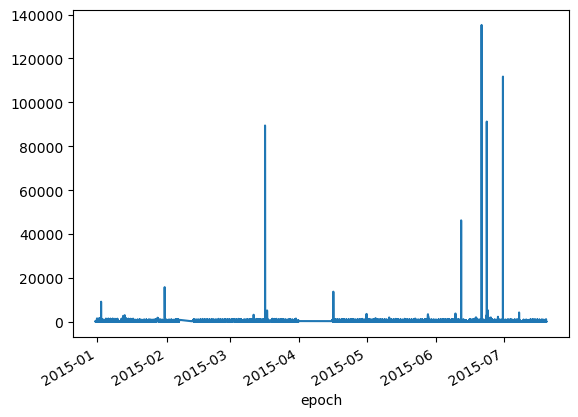

In [5]:
df_train.set_index('epoch')['TxnSysFailures'][10000:200000].plot()

In [6]:
df_train['Time'].values.shape

(255666,)

In [7]:
# drop delta metrics
#my_columns = ['TxnTotal', 'TxnSysFailures', 'TxnSysFailuresPerc',
#       ' TxnCustFailures', 'TxnCustFailuresPerc', ' ConnsTotal', 'ConnsFailed',
#       'ConnsFailedPerc', 'AvgLatency', 'DODSysFailuresDelta', 'DODCustFailuresDelta',
#       'DODConnsFailedDelta', 'DODLatencyDelta', 'WOWSysFailuresDelta',
#       ' WOWCustFailuresDelta', ' WOWConnsFailuresDelta']
my_columns = ['TxnSysFailures', 'TxnSysFailuresPerc',
       ' TxnCustFailures', 'TxnCustFailuresPerc', 'ConnsFailed',
       'ConnsFailedPerc', 'AvgLatency']

In [10]:
df_train = df_raw.copy()
df_train = df_train.reset_index().set_index('epoch').asfreq('60S').interpolate(method='time')

In [11]:
df_train.shape

(377587, 25)

<AxesSubplot:xlabel='epoch'>

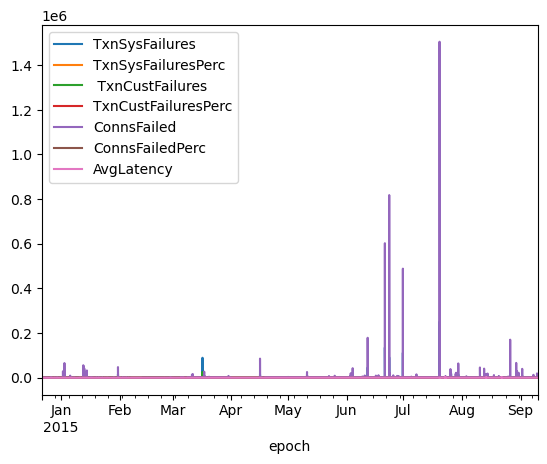

In [13]:
df_train[my_columns].plot()

In [14]:
# slice data
test_data = skiutil.view_as_windows(df_train[my_columns].values, 
         window_shape=(400,len(my_columns)), step=200).squeeze()

In [15]:
# reshape data
test_data = np.swapaxes(test_data, 1, 2)
test_data.shape
train_data = test_data[:949].copy()

In [16]:
# we still expand the features and perform the Radon projections
#  but we don't deal with the covariance matrix
ts_extractor = TimeSeriesFeatureExtractor(train_data.shape[1], train_data.shape[2], 9)
train_feats = ts_extractor.extract(train_data)
test_feats = ts_extractor.extract(test_data)
# Extract Cumulative-Radon features from the input set
radon_extractor = CumulativeRadonFeatures(train_feats.shape[1])
radon_extractor.fit(train_feats)
train_radon = radon_extractor.forward(train_feats)
test_radon = radon_extractor.forward(test_feats)
# Sphere the Radon features
print('Radon features', train_radon.shape)
#zca_sphere = ZCA_Sphering()
#zca_sphere.fit(train_radon)
#test_sph = zca_sphere.transform(test_radon)

(949, 7, 400) torch.Size([949, 7, 400, 1])
4 torch.Size([949, 63, 400])
(949, 7, 400) torch.Size([949, 7, 400, 1])
8 torch.Size([949, 63, 400])
(949, 7, 400) torch.Size([949, 7, 400, 1])
12 torch.Size([949, 63, 400])
(949, 7, 400) torch.Size([949, 7, 400, 1])
16 torch.Size([949, 63, 400])
(949, 7, 400) torch.Size([949, 7, 400, 1])
20 torch.Size([949, 63, 400])
(949, 7, 400) torch.Size([949, 7, 400, 1])
24 torch.Size([949, 63, 400])
(949, 7, 400) torch.Size([949, 7, 400, 1])
28 torch.Size([949, 63, 400])
(949, 7, 400) torch.Size([949, 7, 400, 1])
32 torch.Size([949, 63, 400])
(949, 7, 400) torch.Size([949, 7, 400, 1])
36 torch.Size([949, 63, 400])
(949, 7, 400) torch.Size([949, 7, 400, 1])
40 torch.Size([949, 63, 400])
(1886, 7, 400) torch.Size([1886, 7, 400, 1])
4 torch.Size([1886, 63, 400])
(1886, 7, 400) torch.Size([1886, 7, 400, 1])
8 torch.Size([1886, 63, 400])
(1886, 7, 400) torch.Size([1886, 7, 400, 1])
12 torch.Size([1886, 63, 400])
(1886, 7, 400) torch.Size([1886, 7, 400, 1])
1

In [17]:
# compute the mutual distance between the timeseries snippets
#  with sliced Wasserstein (as average over all 100 projected ECDFs)
dist = radon_extractor.wasserstein(test_feats)

(1886, 1886)


In [ ]:
dist.shape

Text(0.5, 1.0, 'Distances (some examples)')

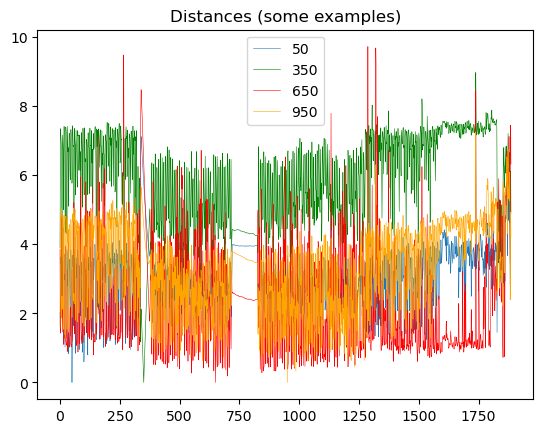

In [18]:
plt.plot(dist[50,:], lw=0.4, label='50')
plt.plot(dist[350,: ], lw=0.4, c='green', label='350')
plt.plot(dist[650,:], lw=0.4, c='red', label='650')
plt.plot(dist[950,:], lw=0.4, c='orange', label='950')

plt.legend()
plt.title('Distances (some examples)')

In [19]:
anomaly_score = np.zeros(dist.shape[0])
for i in range(dist.shape[0]):
    srt = np.sort(dist[i, :])
    #anomaly_score[i] = (srt * srt).mean()
    anomaly_score[i] = srt[:20].mean()

In [20]:
anomaly_score.shape, df_train.shape[0]

((1886,), 377587)

In [21]:
# stretch it back to fit from 1277 timeseries snippets to the original data length
import scipy as sp
spi = sp.interpolate.interp1d(range(anomaly_score.shape[0]), anomaly_score, fill_value='extrapolate')
x_values = (np.linspace(0 , anomaly_score.shape[0], num=df_train.shape[0]))
df_train['dist'] = spi(x_values)

<AxesSubplot:xlabel='epoch'>

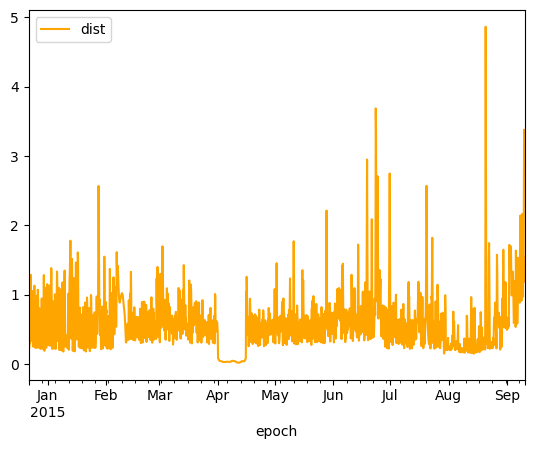

In [23]:
#
df_train[['dist']].plot(c='orange')

In [ ]:
my_columns

<AxesSubplot:xlabel='epoch'>

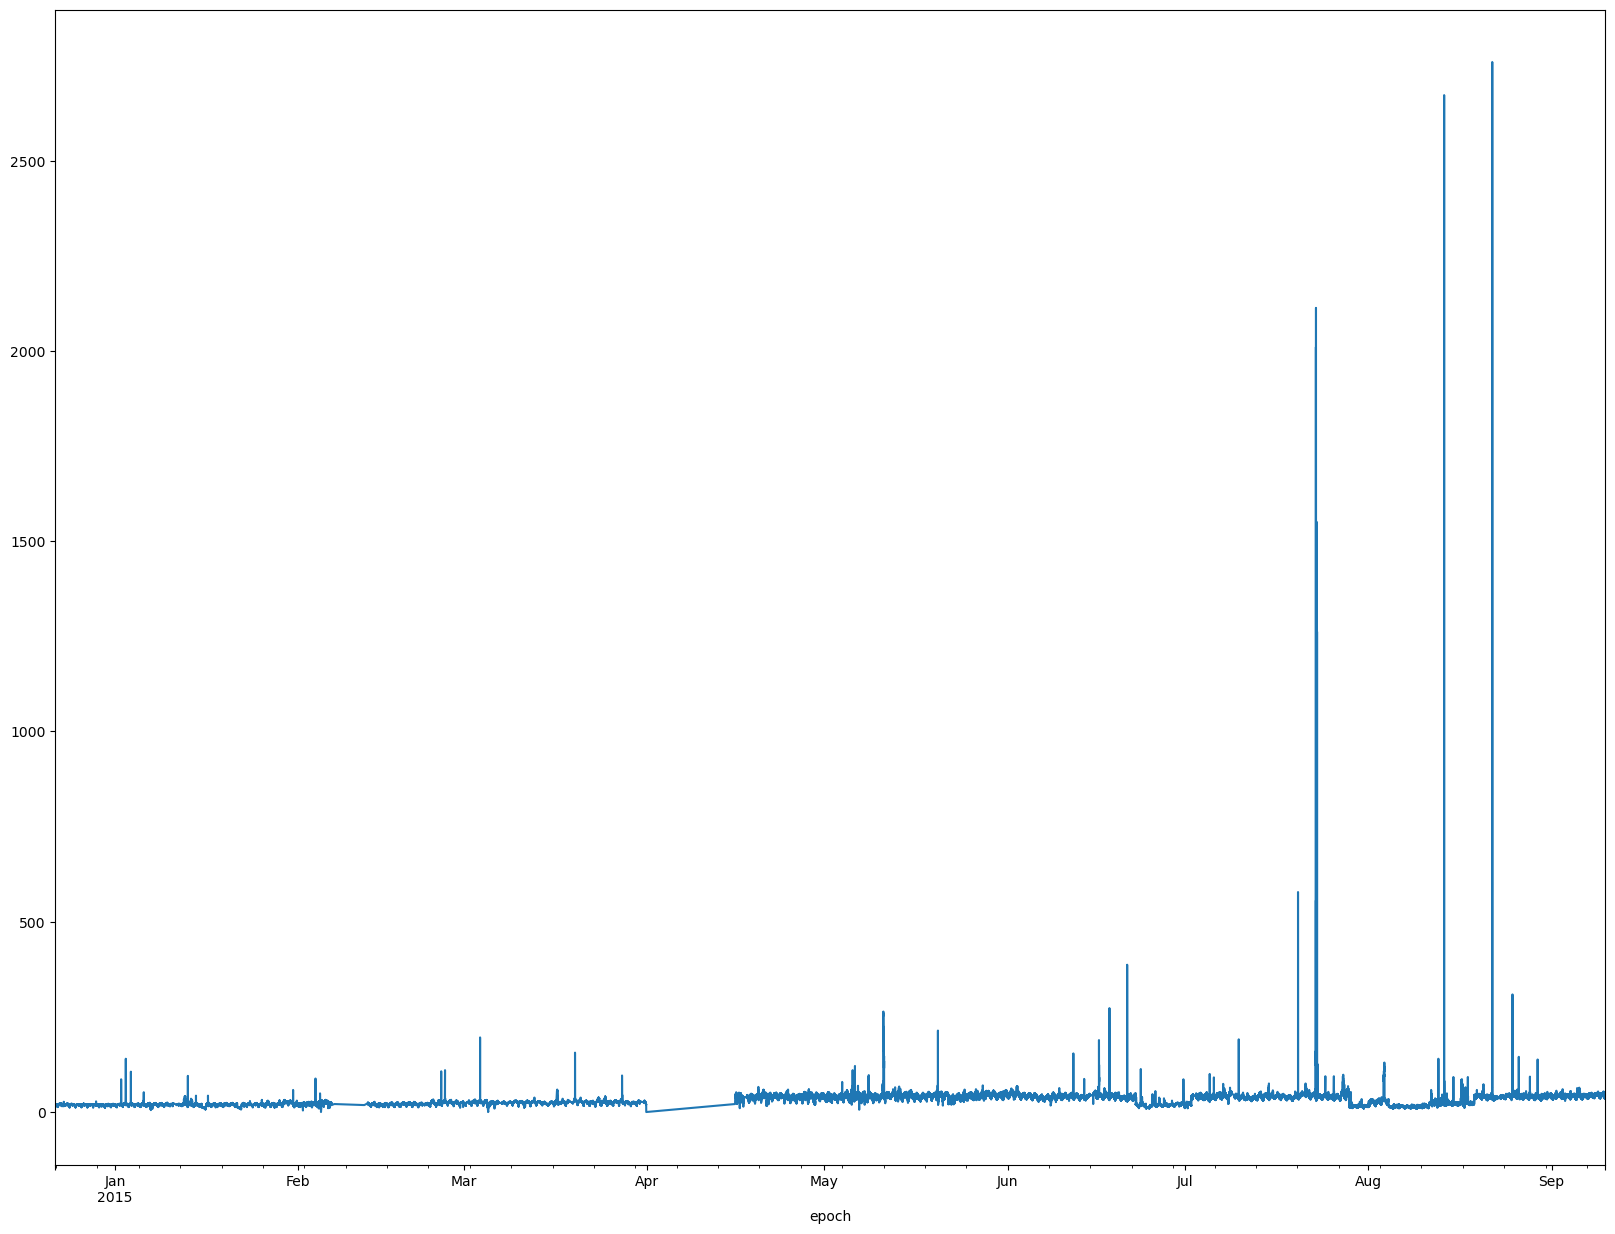

In [24]:
df_train['AvgLatency'].plot(figsize=(20, 15))